In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from itertools import combinations
%matplotlib inline

# How Much is Your Car Worth?

Data about the retail price of 2005 General Motors cars can be found in `car_data.csv`.

The columns are:

1. Price: suggested retail price of the used 2005 GM car in excellent condition.
2. Mileage: number of miles the car has been driven
3. Make: manufacturer of the car such as Saturn, Pontiac, and Chevrolet
4. Model: specific models for each car manufacturer such as Ion, Vibe, Cavalier
5. Trim (of car): specific type of car model such as SE Sedan 4D, Quad Coupe 2D          
6. Type: body type such as sedan, coupe, etc.      
7. Cylinder: number of cylinders in the engine        
8. Liter: a more specific measure of engine size     
9. Doors: number of doors           
10. Cruise: indicator variable representing whether the car has cruise control (1 = cruise)
11. Sound: indicator variable representing whether the car has upgraded speakers (1 = upgraded)
12. Leather: indicator variable representing whether the car has leather seats (1 = leather)

## Tasks, Part 1

1. Find the linear regression equation for mileage vs price.
2. Chart the original data and the equation on the chart.
3. Find the equation's $R^2$ score (use the `.score` method) to determine whether the
equation is a good fit for this data. (0.8 and greater is considered a strong correlation.)

## Tasks, Part 2

1. Use mileage, cylinders, liters, doors, cruise, sound, and leather to find the linear regression equation.
2. Find the equation's $R^2$ score (use the `.score` method) to determine whether the
equation is a good fit for this data. (0.8 and greater is considered a strong correlation.)
3. Find the combination of the factors that is the best predictor for price.

## Tasks, Hard Mode

1. Research dummy variables in scikit-learn to see how to use the make, model, and body type.
2. Find the best combination of factors to predict price.

In [6]:
df = pd.read_csv("car_data.csv")

In [31]:
df.head()

,Price,Mileage,Make,Model,Trim,Type,Cylinder,Liter,Doors,Cruise,Sound,Leather
0,17314.103129,8221,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,1
1,17542.036083,9135,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
2,16218.847862,13196,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
3,16336.913140,16342,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,0
4,16339.170324,19832,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,1


In [11]:
regression = linear_model.LinearRegression()
mileage = df["Mileage"].to_frame()
price = df["Price"].to_frame()
mil_price = regression.fit(mileage, price)

In [12]:
float(mil_price.coef_), float(mil_price.intercept_)

(-0.17252050279124917, 24764.55900606168)

In [13]:
coefficient , intercept = float(mil_price.coef_), float(mil_price.intercept_)

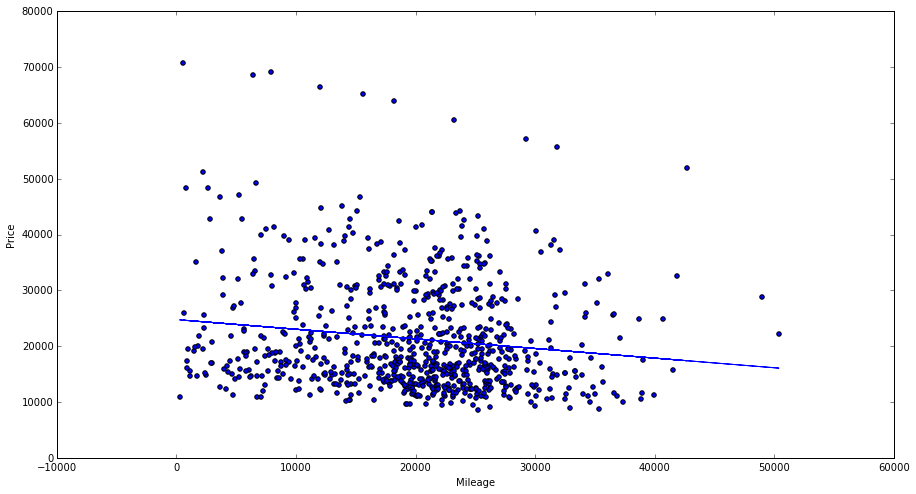

In [27]:
plt.figure(figsize=(15, 8))
plt.scatter(mileage, price)
plt.plot(mileage, mil_price.predict(mileage))
plt.xlabel("Mileage")
plt.ylabel("Price")
plt.show()

In [29]:
r2score = regression.score(mileage, price)
print("R**2 score = {:.2f}".format(r2score))

R**2 score = 0.02


####Looks like a very bad fit.

In [33]:
df.head()

,Price,Mileage,Make,Model,Trim,Type,Cylinder,Liter,Doors,Cruise,Sound,Leather
0,17314.103129,8221,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,1
1,17542.036083,9135,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
2,16218.847862,13196,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
3,16336.913140,16342,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,0
4,16339.170324,19832,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,1


In [36]:
col1 = ["Mileage", "Cylinder", "Liter", "Doors", "Cruise", "Sound", "Leather"]

In [38]:
price = df["Price"]
regression.fit(df[col1], price)
score = regression.score(df[col1], price)
print("R**2 score = {:.2f}".format(score))

R**2 score = 0.45


In [69]:
combos = list(combinations(col1, 6))

In [70]:
choices = []

for combo in combos:
    combo = list(combo)
    input_data = df[combo]
    regr = linear_model.LinearRegression()
    regr.fit(input_data, price)
    score = regr.score(input_data, price)
    choices.append((combo, score))

In [71]:
choices

[(['Mileage', 'Cylinder', 'Liter', 'Doors', 'Cruise', 'Sound'],
  0.42441824017998753),
 (['Mileage', 'Cylinder', 'Liter', 'Doors', 'Cruise', 'Leather'],
  0.43780574153663798),
 (['Mileage', 'Cylinder', 'Liter', 'Doors', 'Sound', 'Leather'],
  0.38271504500215792),
 (['Mileage', 'Cylinder', 'Liter', 'Cruise', 'Sound', 'Leather'],
  0.43014148406475605),
 (['Mileage', 'Cylinder', 'Doors', 'Cruise', 'Sound', 'Leather'],
  0.44569092105870245),
 (['Mileage', 'Liter', 'Doors', 'Cruise', 'Sound', 'Leather'],
  0.42482840454267845),
 (['Cylinder', 'Liter', 'Doors', 'Cruise', 'Sound', 'Leather'],
  0.4265348637809262)]